## Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import torch
from torch import nn,DictType

## Model Implementation

In [2]:
class layer(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(layer,self).__init__()
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.sigmoid= nn.Sigmoid()

    def forward(self,x,weights,bias=None,output_sigmoid=True):
        # weights: nxm
        if output_sigmoid:
            if bias is not None:
                y= self.sigmoid(weights.T @ x + bias) # x: nx1 , y:mx1
            else:
                y= self.sigmoid(weights.T @ x)
        else:
            if bias is not None:
                y= weights.T @ x + bias # x: nx1 , y:mx1
            else:
                y= weights.T @ x
        return y

In [3]:
class backpropagation(nn.Module):
    def __init__(self,num_layers,output_sigmoid=True):
        super(backpropagation,self).__init__()
        self.num_layers=num_layers
        self.output_sigmoid=output_sigmoid

    def sigmoid_derivation(self,x):
        # It is assumed that the input value has already gone through the sigmoid function
        # So, we take the input in the form of oj
        return x*(1-x)
    def output_layer_delta(self,desired,output):
        # Desired should be taken as one element. It states the desired value of one node
        # Output should be taken as one element. It states the output value of one node
        error= desired - output # tj - oj at the output layer
        if self.output_sigmoid:
            sigmoid_deriv = self.sigmoid_derivation(output) # given oj instead of sigmoid(sj)
            delta_output = error*sigmoid_deriv
        else:
            delta_output=error
        return delta_output
    def hidden_layer_delta(self,desired,layer_num,weight,output,output_next_layers:DictType,weight_next_layers:DictType):
        # Expected desired shape is 1-D vector of size of output dimension
        # output_next_layers states the output of the layers. Expected format is dictionary
        # output_next_layers should contain number of all output vectors
        # output_next_layers feature names should be in format of for instance "layer_3" if it contains third layer's outputs
        # weight_next_layers contains all the weights
        # output is the 1-D vector output of corresponding node of corresponding layer (with index j)
        # weight should be taken as all the weights of the next layer for the corresponding node
        # weight expected shape is 1-D vector of size whatever the length of weight is
        # so let's say we are at layer (k+1) and take j as the node index of (k+1)th layer
        # take l as the node index of (k+2)th layer
        # then, delta(l)*w(jl)*sigmoid_derivative(j) will be summed over node index l
        if layer_num <(self.num_layers):
            # Now, we consider the layers before the (self.num_layers - 1)th layer
            # Here we need to reach the last layer's delta recursively
            # It will dive deep into the delta equations till it reaches the delta of output layer
            # Then with that equation, calculates and returns the corresponding delta
            sigmoid_deriv = self.sigmoid_derivation(output)
            next_layer_num= layer_num+1
            outputs_next = output_next_layers[f'layer_{next_layer_num}']
            next_weight_num=next_layer_num+1
            try:
                weights_next = weight_next_layers[f'layer_{next_weight_num}'] # Matrix: lxn
            except:
                weights_next = weight_next_layers[f'layer_{next_layer_num}'] # When the last layer has come, this index will go out of bound.Since we do not use weights for the last layer's delta, assign the last weights!
            delta_j=0
            for l in range(weight.shape[0]):
                if next_layer_num <self.num_layers:
                    delta_next_layer_l = self.hidden_layer_delta(desired,next_layer_num,weights_next[l,:].reshape((weights_next.shape[1])),outputs_next[l], output_next_layers, weight_next_layers )
                elif next_layer_num==self.num_layers:
                    delta_next_layer_l = self.output_layer_delta(desired[l],outputs_next[l])
                weight_j_l = weight[l]
                delta_j += delta_next_layer_l*weight_j_l*sigmoid_deriv
            
            return delta_j

    def weight_update(self,desired,learning_rate,layer_num,output_next_layers:DictType,weight_next_layers:DictType):
        # sample is the input vector fed into the model
        # layer_num means the layer number we are at
        # desired is the 1-D target value vector
        # weight is a weight matrix for the connections between k and (k+1)th layers: size_k x size_k_plus_one
        # output is a 1-D output vector of (k+1)th layer
        # output_next_layers is dictionary of 1-D outputs of all layers
        # weight_next_layers is dictionary of weight matrices of all layers
        weight = weight_next_layers[f'layer_{layer_num}']
        (size_k,size_k_plus_one) = weight.shape


        delta_output_vector = torch.Tensor(size_k_plus_one)
        output= output_next_layers[f'layer_{layer_num}']

        if layer_num==1:
            output_i=output_next_layers['sample']
        else:
            previous_layer_num=layer_num-1
            output_i = output_next_layers[f'layer_{previous_layer_num}'] # output vector of kth layer of size_k

        
        if layer_num==self.num_layers:
            for j in range(size_k_plus_one): # j as the index of (k+1)th layer
                # calculate delta values for each node of the (k+1)th layer
                delta_output_vector[j]=self.output_layer_delta(desired[j],output[j])

        elif layer_num < self.num_layers:
            layer_next=layer_num+1
            weights_next = weight_next_layers[f'layer_{layer_next}']
            (size_k_plus_one,size_k_plus_two) = weights_next.shape
            for j in range(size_k_plus_one):
                delta_output_vector[j]=self.hidden_layer_delta(desired,layer_num,weights_next[j,:].reshape((size_k_plus_two)),output[j], output_next_layers, weight_next_layers )
        
        weight_update_matrix= learning_rate * (output_i.reshape((size_k,1)) @ delta_output_vector.reshape((1,size_k_plus_one))) # size_k x size_k_plus_one

        if (layer_num==1) | (layer_num==self.num_layers):
            bias_update = torch.sum(learning_rate*delta_output_vector) # 1-D vector of size size_k_plus_one
            # bias_update=bias_update.reshape((bias_update.shape[0],1))
        else:
            bias_update=None

        return weight_update_matrix,bias_update
        



    def forward(self,desired,outputs:DictType,weights:DictType,learning_rate):
        weight_update_matrices = {}
        weights_updated ={}
        for i in range(self.num_layers):
            layer_num=i+1
            weight_update_matrices[f'layer_{layer_num}'],bias_update = self.weight_update(desired,learning_rate,layer_num,outputs,weights)
            weights_updated[f'layer_{layer_num}'] = weight_update_matrices[f'layer_{layer_num}'] + weights[f'layer_{layer_num}']

            if layer_num==1:
                weights_updated['bias_input'] = bias_update + weights['bias_input']
            elif layer_num==self.num_layers:
                weights_updated['bias_output'] = bias_update + weights['bias_output']
        
        return weights_updated



In [4]:
class MLP(nn.Module):
    def __init__(self,num_layers,input_dim,output_dim,hidden_dim,output_sigmoid=True) -> None:
        super(MLP,self).__init__()
        self.num_layers=num_layers
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.hidden_dim=hidden_dim
        self.layers= nn.ModuleList([layer(hidden_dim, hidden_dim) for i in range(num_layers-2)])
        self.layers.insert(0,layer(input_dim, hidden_dim))
        self.layers.insert(num_layers-1,layer(input_dim, hidden_dim))
        self.output_sigmoid=output_sigmoid

    def weight_init(self):
        weights={}
        for i in range(self.num_layers):
            layer_num= i+1
            if i ==0:
                w = torch.empty(self.input_dim, self.hidden_dim)
                nn.init.normal_(w)
                weights[f'layer_{layer_num}']= w
                weights['bias_input'] = torch.rand(size=(self.hidden_dim,1))
            elif i==self.num_layers-1:
                w = torch.empty(self.hidden_dim, self.output_dim)
                nn.init.normal_(w)
                weights[f'layer_{layer_num}']= w
                weights['bias_output'] = torch.rand(size=(self.output_dim,1))
            else:
                w = torch.empty(self.hidden_dim, self.hidden_dim)
                nn.init.normal_(w)
                weights[f'layer_{layer_num}']= w    

        return weights

    def forward(self,sample,weights):
        outputs = {}
        outputs['sample']= sample

        output=sample.reshape((sample.shape[0],1))
        for i in range(self.num_layers):
            layer_num=i+1
            weight = weights[f'layer_{layer_num}']
            if layer_num==1:
                output = self.layers[i](output,weight,weights['bias_input'])
            elif layer_num==self.num_layers:
                if self.output_sigmoid:
                    output = self.layers[i](output,weight,weights['bias_output'])
                else:
                    output = self.layers[i](output,weight,weights['bias_output'],output_sigmoid=False)
            else:
                output = self.layers[i](output,weight)
            
            outputs[f'layer_{layer_num}']=output.reshape((output.shape[0]))

        return output.reshape((output.shape[0])),outputs, weights                 

In [5]:
def training(epoch,threshold,data,desired,model,backpropagation,learning_rate,validation_set=None,validation_desired=None):
    (N,dim) = data.shape
    losses=torch.zeros(epoch)
    val_losses=torch.zeros(epoch)
    weights=model.weight_init()
    for i in range(epoch):
        
        if validation_set is not None:
            (N_val,dim) = validation_set.shape
            val_loss=0
            for sample_index in range(N_val):

                sample = data[sample_index,:].reshape((dim,1))

                predictions,outputs, weights =model(sample,weights)

                val_loss += sum((predictions-validation_desired[sample_index])**2)/2

            val_losses[i]= val_loss/N_val   


        loss=0
        for sample_index in range(N):

            sample = data[sample_index,:].reshape((dim,1))

            predictions,outputs, weights =model(sample,weights)
                        
            weights = backpropagation(desired[sample_index],outputs,weights,learning_rate)

            loss += sum((predictions-desired[sample_index])**2)/2

        losses[i]= loss/N


        if i%10==0:
            print(f'Training loss at epoch {i}: {losses[i]}')  
            print(f'Validation loss at epoch {i}: {val_losses[i]}')  

        if loss/N < threshold:
            break   
 
    return losses,weights,val_losses

In [6]:
def classify(data,model,weights):
    N,dim = data.shape

    predictions=torch.zeros(N,1)
    for i in range(N):
        prediction,output_dict,weight_dict=model(data[i],weights)
        if prediction[0] >=0.5:
            predictions[i,0]=1
        else:
            predictions[i,0]=0
    
    return predictions

In [7]:
def testing(test,model,weights):
    N,dim = test.shape

    predictions=torch.zeros(N)
    for i in range(N):
        prediction,output_dict,weight_dict=model(test[i],weights)
        predictions[i]= prediction
    
    return predictions

In [8]:
def classify_multilabel(data,model,weights):
    N,dim = data.shape

    predictions=torch.zeros(N,10)
    actual_predictions=torch.zeros(N,10)
    for i in range(N):
        prediction,output_dict,weight_dict=model(data[i],weights)
        actual_predictions[i,:]=prediction.reshape((10))
        predictions[i,:]= (prediction==prediction.max()).int().reshape((10))
    
    return predictions,actual_predictions


def visualization(test_set,predictions,test_targets):
    revised_predictions= predictions[:,0]*0 + predictions[:,1]*1 + predictions[:,2]*2 + predictions[:,3]*3 + predictions[:,4]*4 + predictions[:,5]*5 + predictions[:,6]*6 + predictions[:,7]*7 + predictions[:,8]*8 + predictions[:,9]*9
    revised_predictions=revised_predictions.reshape((200))
    revised_targets=test_targets.reshape((200))
    accuracy_total=torch.zeros(10)
    for k in range(10):
        accuracy= 100*sum((revised_targets[k*20:(k+1)*20]-revised_predictions[k*20:(k+1)*20])==0)/20
        accuracy_total[k]=accuracy
        fig, axs = plt.subplots(4, 5) # Plot them one-by-one
        fig.set_figwidth(10)
        fig.set_figheight(7)
        fig.suptitle(f'Predictions and Images of Digit {k}, %{accuracy}',fontsize=20)
        for i in range(4):
            for j in range(5):
                index=k*20+(i)*5+j
                axs[i,j].imshow(test_set[index,:].reshape((8,8)))
                axs[i,j].set_title(f"{revised_predictions[index]}")
                axs[i,j].axis('off')
        fig.show()

    return sum(accuracy_total)/10

## Binary XOR Function

In [135]:
#XOR
data=torch.Tensor([[0,0],[0,1],[1,0],[1,1]])
desired=torch.Tensor([[0,1,1,0]]).T

In [136]:
backward = backpropagation(3)
model = MLP(num_layers=3,input_dim=2,output_dim=1,hidden_dim=2)

In [ ]:
losses,weights,_ = training(10000,0.001,data,desired,model,backward,0.2)

In [341]:
fig = go.Figure(data=go.Line(
    x=np.array(list(range(10000)))+1,
    y=losses,
    name='Total Cost',
    mode='lines',
    line_shape='spline',
    marker=dict(
        color = 'red'
    )
))

fig.update_layout(height=800, width=800,
                  showlegend=False,
                  title='Cost Function vs. Epoch',
                  xaxis_title='Epoch',
                  yaxis_title='Cost')


fig.show()

In [342]:
predictions = classify(data,model,weights)

In [344]:
new_test= torch.concatenate([data,predictions],1)
predicted_ones=new_test[new_test[:,2]==1]
predicted_zeros=new_test[new_test[:,2]==0]

In [345]:
fig=go.Figure()


fig.add_trace(go.Scatter(
    x=predicted_ones[:,0],
    y=predicted_ones[:,1],
    name='Predicted Ones',
    mode='markers',
    marker=dict(
        size=25,
        color = 'blue'
    )
))

fig.add_trace(go.Scatter(
    x=predicted_zeros[:,0],
    y=predicted_zeros[:,1],
    name='Predicted Zeros',
    mode='markers',
    marker=dict(
        size=25,
        color = 'red'
    )
))

fig.update_layout(height=800, width=800,
                  
                  title='Predictions of the Model',
                  scene = dict(xaxis=dict(title='x'),
                               yaxis=dict(title='y')
                               )
)

fig.show()

## Function Approximation

In [57]:
x=torch.rand((60))*2*torch.pi
val=torch.rand((25))*2*torch.pi
x=x.sort().values
val=val.sort().values
f_x= torch.sin(x) + 2*torch.cos(x) + torch.normal(0, 0.2, size=(1,60)).reshape((60))
f_x_desired= torch.sin(x) + 2*torch.cos(x)
validation=torch.sin(val) + 2*torch.cos(val) + torch.normal(0, 0.2, size=(1,25)).reshape((25))
val_desired=torch.sin(val) + 2*torch.cos(val)

In [58]:
x_axis= torch.linspace(0,2*torch.pi,10000)
y_axis= torch.sin(x_axis) + 2*torch.cos(x_axis)

fig = go.Figure(data=go.Line(
    x=x_axis,
    y=y_axis,
    name='Desired Function',
    mode='lines',
    line_shape='spline',
    marker=dict(
        color = 'red'
    )
))


fig.add_trace(go.Scatter(
    x=x,
    y=f_x,
    name='Data Points',
    mode='markers',
    # line_shape='spline',
    line=dict(
        width=2,
        color = 'blue'
    )
))

fig.update_layout(height=800, width=800,
                  showlegend=True,
                  title='Data Points Visualization',
                  xaxis_title='x',
                  yaxis_title='f(x)')


fig.show()

In [147]:
backward = backpropagation(4,output_sigmoid=False)
model = MLP(num_layers=4,input_dim=1,output_dim=1,hidden_dim=2,output_sigmoid=False)

In [165]:
losses,weights,val_losses = training(1000,0.05,f_x.reshape((60,1)),f_x_desired.reshape((60,1)),model,backward,0.01,validation_set=validation.reshape((25,1)),validation_desired=val_desired.reshape((25,1)))

In [162]:
fig = go.Figure(data=go.Line(
    x=np.array(list(range(1000)))+1,
    y=losses,
    name='Training Cost',
    mode='lines',
    line_shape='spline',
    marker=dict(
        color = 'red'
    )
))

fig.add_trace(go.Line(
    x=np.array(list(range(1000)))+1,
    y=val_losses,
    name='Validation Cost',
    mode='lines',
    line_shape='spline',
    marker=dict(
        color = 'blue'
    )
))

fig.update_layout(height=800, width=800,
                  showlegend=True,
                  title='Cost Functions vs. Epoch',
                  xaxis_title='Epoch',
                  yaxis_title='Cost')


fig.show()

In [128]:
test=torch.rand((25))*2*torch.pi
test=test.sort().values

test_data= torch.sin(test) + 2*torch.cos(test) + torch.normal(0, 0.2, size=(1,25)).reshape((25))
test_desired= torch.sin(test) + 2*torch.cos(test)

In [166]:
predictions=testing(test_data.reshape((25,1)),model,weights)

In [167]:
x_axis= torch.linspace(0,2*torch.pi,10000)
y_axis= torch.sin(x_axis) + 2*torch.cos(x_axis)

fig = go.Figure(data=go.Line(
    x=x_axis,
    y=y_axis,
    name='Desired Function',
    mode='lines',
    line_shape='spline',
    marker=dict(
        color = 'red'
    )
))

fig.add_trace(go.Scatter(
    x=test,
    y=predictions,
    name='Predicted Function',
    mode='lines',
    line_shape='spline',
    line=dict(
        width=2,
        color = 'blue'
    )
))

fig.add_trace(go.Scatter(
    x=test,
    y=test_data,
    name='Test Data Points',
    mode='markers',
    line=dict(
        width=2,
        color = 'green'
    )
))

fig.update_layout(height=800, width=800,
                  showlegend=True,
                  title='Desired vs. Predicted Functions',
                  xaxis_title='Input Range',
                  yaxis_title='Output Range')


fig.show()

## Optical Recognition of Handwritten Digits

In [17]:
with open('C:/Users/User/Desktop/EE550/SERIN_MELIH_project4/optdigits.tes') as f:
    lines = f.readlines()

In [18]:
for i in range(len(lines)):
    lines[i]=torch.Tensor(np.array(lines[i][:-1].split(','),dtype=int))

lines=torch.Tensor(np.array(lines))

In [19]:
# Data Preprocessing

training_set= torch.zeros((1000,64))
training_targets= torch.zeros((1000,1))
val_set= torch.zeros((200,64))
val_targets= torch.zeros((200,1))
test_set= torch.zeros((200,64))
test_targets= torch.zeros((200,1))

training_set[:100,:] = lines[lines[:,64]==0][:100,:64]
test_set[:20,:] = lines[lines[:,64]==0][100:120,:64]
val_set[:20,:] = lines[lines[:,64]==0][120:140,:64]
training_targets[:100,0] = lines[lines[:,64]==0][:100,64]
test_targets[:20,0] = lines[lines[:,64]==0][100:120,64]
val_targets[:20,0] = lines[lines[:,64]==0][120:140,64]

training_set[100:200,:] = lines[lines[:,64]==1][:100,:64]
test_set[20:40,:] = lines[lines[:,64]==1][100:120,:64]
val_set[20:40,:] = lines[lines[:,64]==1][120:140,:64]
training_targets[100:200,0] = lines[lines[:,64]==1][:100,64]
test_targets[20:40,0] = lines[lines[:,64]==1][100:120,64]
val_targets[20:40,0] = lines[lines[:,64]==1][120:140,64]

training_set[200:300,:] = lines[lines[:,64]==2][:100,:64]
test_set[40:60,:] = lines[lines[:,64]==2][100:120,:64]
val_set[40:60,:] = lines[lines[:,64]==2][120:140,:64]
training_targets[200:300,0] = lines[lines[:,64]==2][:100,64]
test_targets[40:60,0] = lines[lines[:,64]==2][100:120,64]
val_targets[40:60,0] = lines[lines[:,64]==2][120:140,64]

training_set[300:400,:] = lines[lines[:,64]==3][:100,:64]
test_set[60:80,:] = lines[lines[:,64]==3][100:120,:64]
val_set[60:80,:] = lines[lines[:,64]==3][120:140,:64]
training_targets[300:400,0] = lines[lines[:,64]==3][:100,64]
test_targets[60:80,0] = lines[lines[:,64]==3][100:120,64]
val_targets[60:80,0] = lines[lines[:,64]==3][120:140,64]

training_set[400:500,:] = lines[lines[:,64]==4][:100,:64]
test_set[80:100,:] = lines[lines[:,64]==4][100:120,:64]
val_set[80:100,:] = lines[lines[:,64]==4][120:140,:64]
training_targets[400:500,0] = lines[lines[:,64]==4][:100,64]
test_targets[80:100,0] = lines[lines[:,64]==4][100:120,64]
val_targets[80:100,0] = lines[lines[:,64]==4][120:140,64]

training_set[500:600,:] = lines[lines[:,64]==5][:100,:64]
test_set[100:120,:] = lines[lines[:,64]==5][100:120,:64]
val_set[100:120,:] = lines[lines[:,64]==5][120:140,:64]
training_targets[500:600,0] = lines[lines[:,64]==5][:100,64]
test_targets[100:120,0] = lines[lines[:,64]==5][100:120,64]
val_targets[100:120,0] = lines[lines[:,64]==5][120:140,64]

training_set[600:700,:] = lines[lines[:,64]==6][:100,:64]
test_set[120:140,:] = lines[lines[:,64]==6][100:120,:64]
val_set[120:140,:] = lines[lines[:,64]==6][120:140,:64]
training_targets[600:700,0] = lines[lines[:,64]==6][:100,64]
test_targets[120:140,0] = lines[lines[:,64]==6][100:120,64]
val_targets[120:140,0] = lines[lines[:,64]==6][120:140,64]

training_set[700:800,:] = lines[lines[:,64]==7][:100,:64]
test_set[140:160,:] = lines[lines[:,64]==7][100:120,:64]
val_set[140:160,:] = lines[lines[:,64]==7][120:140,:64]
training_targets[700:800,0] = lines[lines[:,64]==7][:100,64]
test_targets[140:160,0] = lines[lines[:,64]==7][100:120,64]
val_targets[140:160,0] = lines[lines[:,64]==7][120:140,64]

training_set[800:900,:] = lines[lines[:,64]==8][:100,:64]
test_set[160:180,:] = lines[lines[:,64]==8][100:120,:64]
val_set[160:180,:] = lines[lines[:,64]==8][120:140,:64]
training_targets[800:900,0] = lines[lines[:,64]==8][:100,64]
test_targets[160:180,0] = lines[lines[:,64]==8][100:120,64]
val_targets[160:180,0] = lines[lines[:,64]==8][120:140,64]

training_set[900:,:] = lines[lines[:,64]==9][:100,:64]
test_set[180:,:] = lines[lines[:,64]==9][100:120,:64]
val_set[180:,:] = lines[lines[:,64]==9][120:140,:64]
training_targets[900:,0] = lines[lines[:,64]==9][:100,64]
test_targets[180:,0] = lines[lines[:,64]==9][100:120,64]
val_targets[180:,0] = lines[lines[:,64]==9][120:140,64]


targets = torch.zeros((1000,10))

targets[:,0]=(training_targets==0).int().reshape((1000))
targets[:,1]=(training_targets==1).int().reshape((1000))
targets[:,2]=(training_targets==2).int().reshape((1000))
targets[:,3]=(training_targets==3).int().reshape((1000))
targets[:,4]=(training_targets==4).int().reshape((1000))
targets[:,5]=(training_targets==5).int().reshape((1000))
targets[:,6]=(training_targets==6).int().reshape((1000))
targets[:,7]=(training_targets==7).int().reshape((1000))
targets[:,8]=(training_targets==8).int().reshape((1000))
targets[:,9]=(training_targets==9).int().reshape((1000))

targets_test = torch.zeros((200,10))

targets_test[:,0]=(test_targets==0).int().reshape((200))
targets_test[:,1]=(test_targets==1).int().reshape((200))
targets_test[:,2]=(test_targets==2).int().reshape((200))
targets_test[:,3]=(test_targets==3).int().reshape((200))
targets_test[:,4]=(test_targets==4).int().reshape((200))
targets_test[:,5]=(test_targets==5).int().reshape((200))
targets_test[:,6]=(test_targets==6).int().reshape((200))
targets_test[:,7]=(test_targets==7).int().reshape((200))
targets_test[:,8]=(test_targets==8).int().reshape((200))
targets_test[:,9]=(test_targets==9).int().reshape((200))


targets_val = torch.zeros((200,10))

targets_val[:,0]=(val_targets==0).int().reshape((200))
targets_val[:,1]=(val_targets==1).int().reshape((200))
targets_val[:,2]=(val_targets==2).int().reshape((200))
targets_val[:,3]=(val_targets==3).int().reshape((200))
targets_val[:,4]=(val_targets==4).int().reshape((200))
targets_val[:,5]=(val_targets==5).int().reshape((200))
targets_val[:,6]=(val_targets==6).int().reshape((200))
targets_val[:,7]=(val_targets==7).int().reshape((200))
targets_val[:,8]=(val_targets==8).int().reshape((200))
targets_val[:,9]=(val_targets==9).int().reshape((200))

In [20]:
backward = backpropagation(4)
model = MLP(num_layers=4,input_dim=64,output_dim=10,hidden_dim=16)

In [21]:
losses,weights,losses_val = training(70,0.01,training_set,targets,model,backward,0.05,val_set,targets_val)

: 

In [19]:
fig = go.Figure(data=go.Line(
    x=np.array(list(range(300)))+1,
    y=losses,
    name='Training Cost',
    mode='lines',
    line_shape='spline',
    marker=dict(
        color = 'red'
    )
))

fig.add_trace(go.Line(
    x=np.array(list(range(300)))+1,
    y=losses_val,
    name='Validation Cost',
    mode='lines',
    line_shape='spline',
    marker=dict(
        color = 'blue'
    )
))

fig.update_layout(height=800, width=800,
                  showlegend=True,
                  title='Cost Functions vs. Epoch',
                  xaxis_title='Epoch',
                  yaxis_title='Cost')


fig.show()

In [20]:
predictions,actual_predictions=classify_multilabel(test_set,model,weights)

C:\Users\User\AppData\Local\Temp\ipykernel_63780\2059833842.py:32: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



tensor(85.5000)

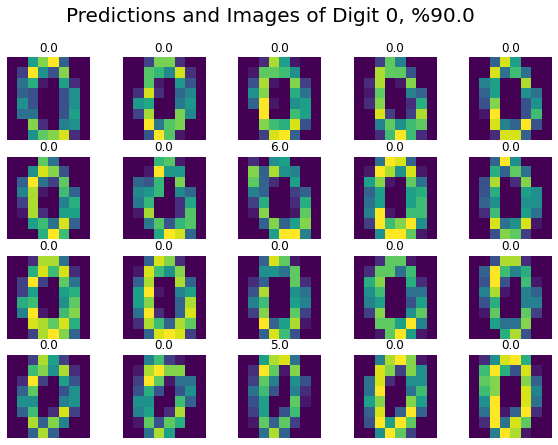

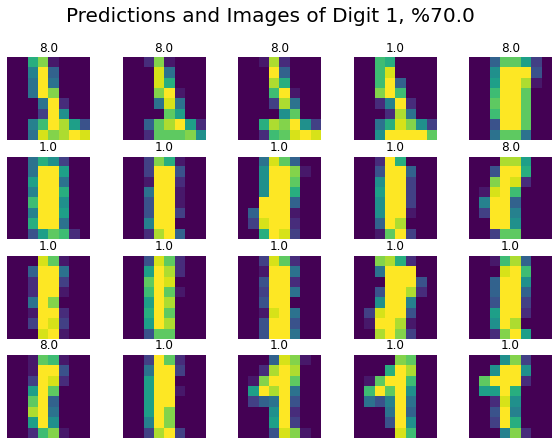

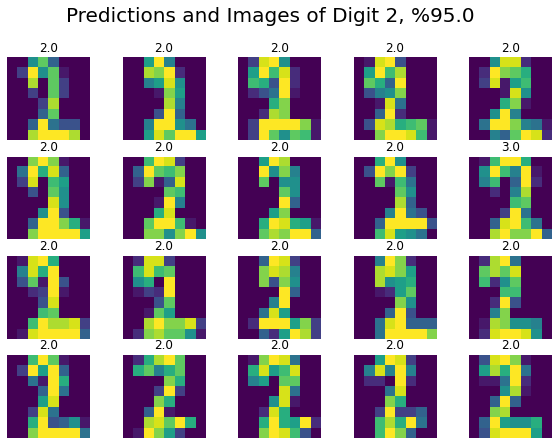

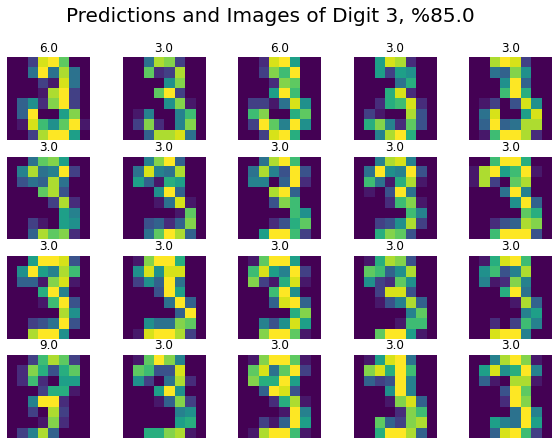

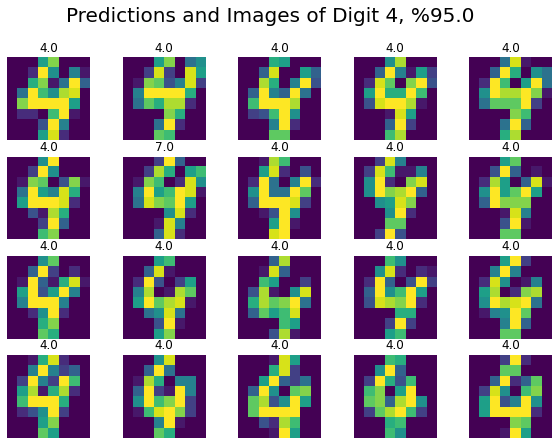

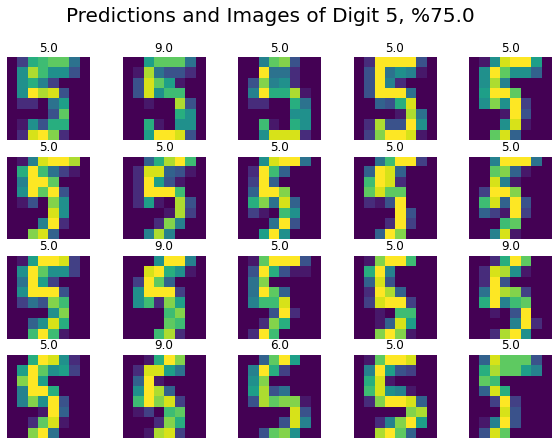

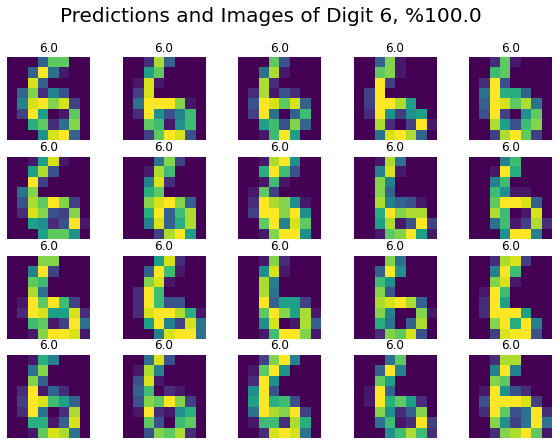

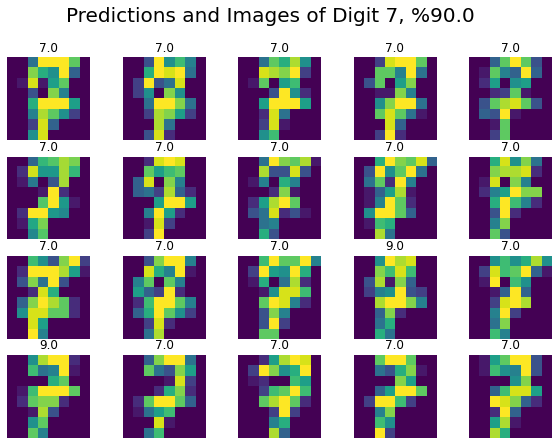

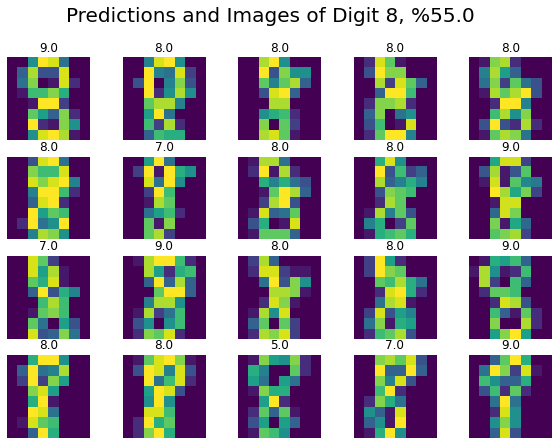

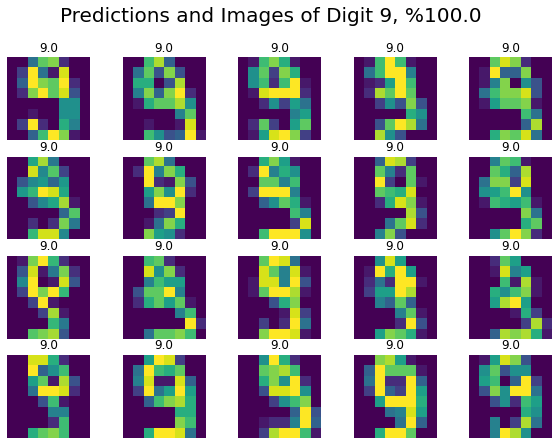

In [21]:
visualization(test_set,predictions,test_targets)